In [8]:
%load_ext autoreload
%autoreload 2

from multicamera_acquisition.acquisition import refactor_acquire_video, AcquisitionLoop, reset_loggers
from multicamera_acquisition.writer import NVC_Writer, FFMPEG_Writer
from multicamera_acquisition.interfaces.microcontroller import Microcontroller 
from multicamera_acquisition.config import (
    load_config,
)

import datetime
from os.path import join, exists

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Recording params
fps = 120
rec_time_s = 10
base_path = R'D:/Jonah/20240125_pbn-tac1_photom/data'
mouse = "tmp"
logging_level = "INFO"
config_filepath = R'D:/Jonah/2023_12_26_6cam_testing/JP219_6+2_120hz.yaml'

In [10]:
config = load_config(config_filepath)

In [11]:
config["microcontroller"]['random_output_pins'].extend([20]) 
config["microcontroller"]['random_output_pins']

[34, 20]

In [12]:
config["cameras"]["side1"]["display"]["display_frames"] = True
config["acq_loop"]['dropped_frame_warnings'] = False
config["acq_loop"]["downsample"] = 12
config["rt_display"]["display_every_n"] = 6

In [13]:
datestr = datetime.datetime.now().strftime("%Y%m%d")
recording_name = f"{datestr}_{mouse}"
base_path = join(base_path, mouse)
recording_name

'20240129_tmp'

2024-01-29 10:34:18,773 - main_acq_logger - INFO - Finding microcontroller...
2024-01-29 10:34:19,665 - main_acq_logger - INFO - Found ready microcontroller on port: COM3
2024-01-29 10:34:19,667 - main_acq_logger - INFO - Opening subprocesses and cameras, this may take a moment...
2024-01-29 10:34:29,950 - main_acq_logger - INFO - Starting cameras...
2024-01-29 10:34:30,786 - main_acq_logger - INFO - Starting microcontroller...


Recording Progress: 90.0% (9 / 10 sec)

2024-01-29 10:34:41,651 - main_acq_logger - INFO - Ending processes, this may take a moment...
2024-01-29 10:34:43,040 - main_acq_logger - INFO - Processed ended
2024-01-29 10:34:43,043 - main_acq_logger - INFO - Done.


Recording Progress: 100%

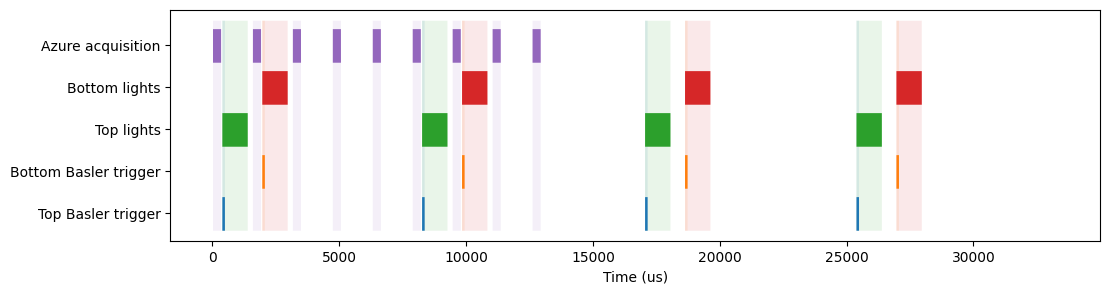

In [14]:
reset_loggers()

save_loc, first_video_file_name, full_config = refactor_acquire_video(
    base_path,
    config,
    recording_duration_s=rec_time_s,
    recording_name=recording_name,
    append_datetime=False,
    overwrite=False,
    logging_level=logging_level
)

## Plot data

In [15]:
from pathlib2 import Path
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.set_loglevel (level = 'warning')

azure_bottom


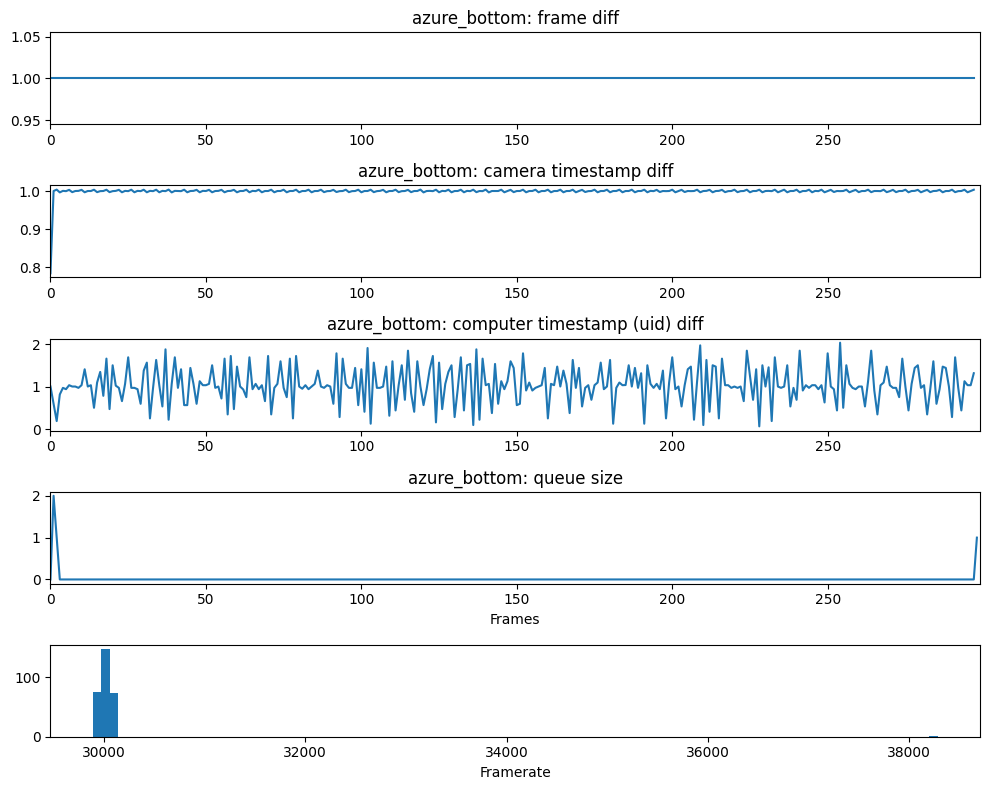

0.009926233000000001
30021.459298809525
azure_top


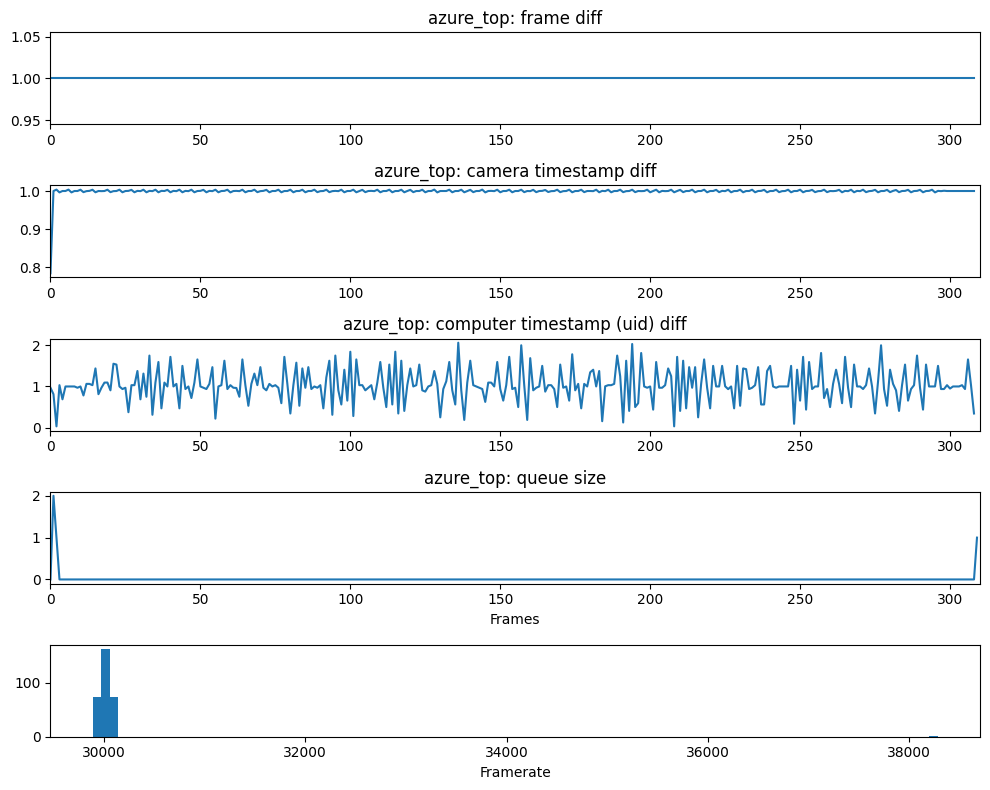

0.010292811
30020.953459652566
bottom


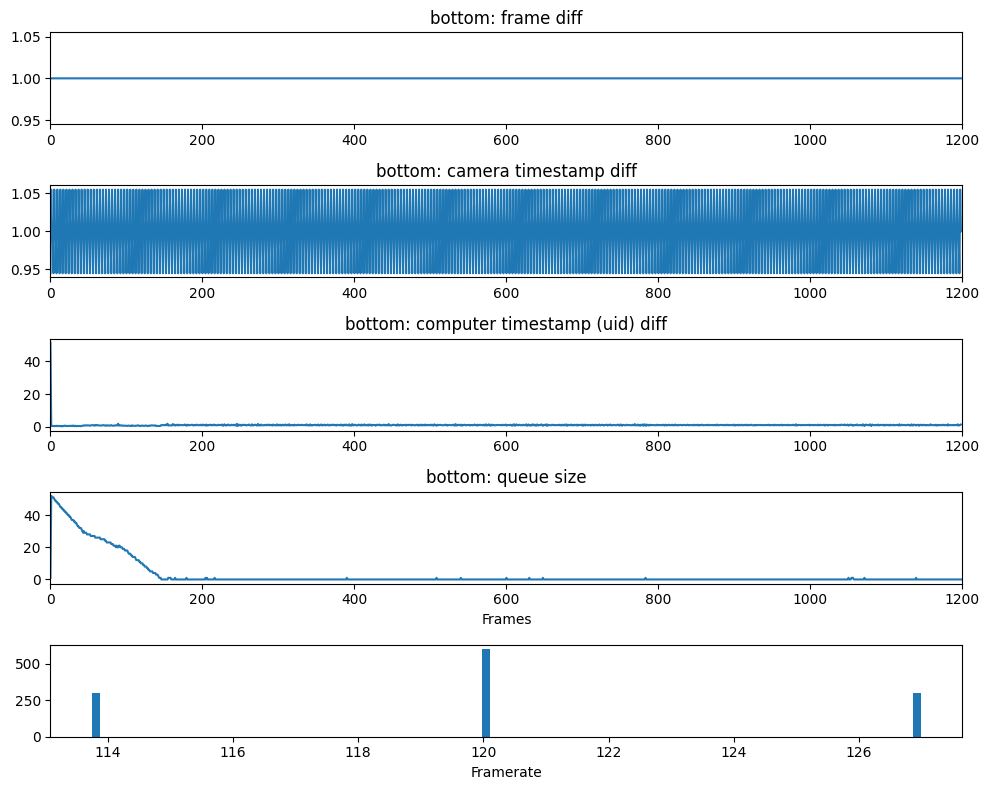

9.991843390000001
119.99787758883198
side1


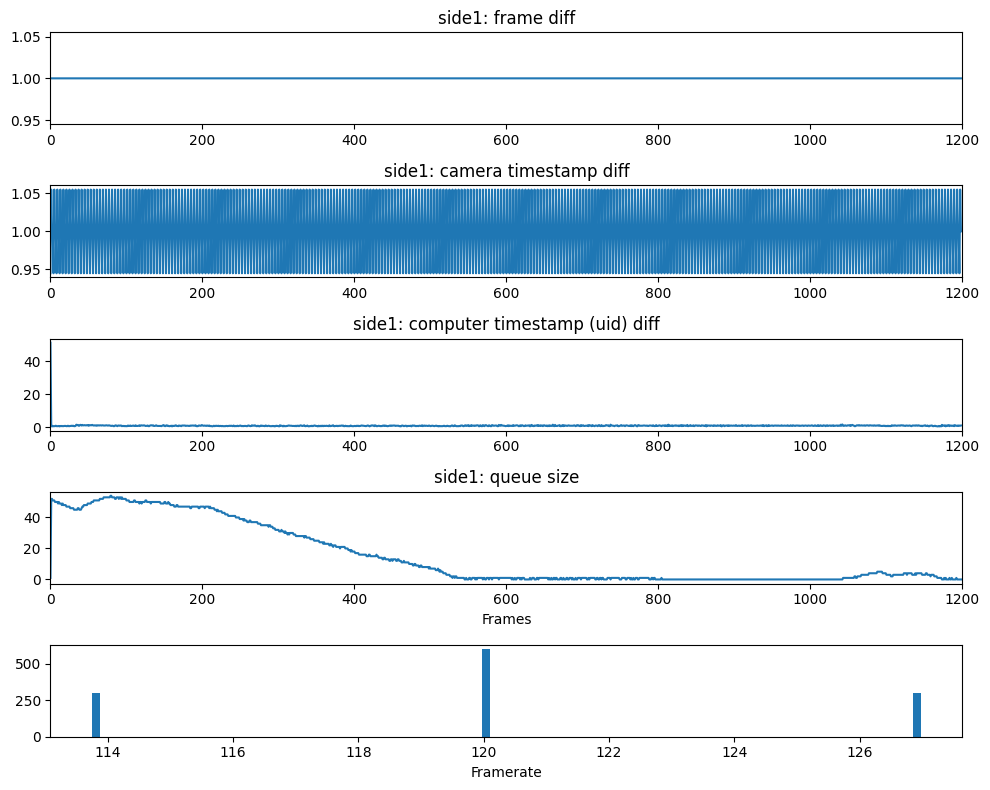

9.99178707
119.99855397238764
side2


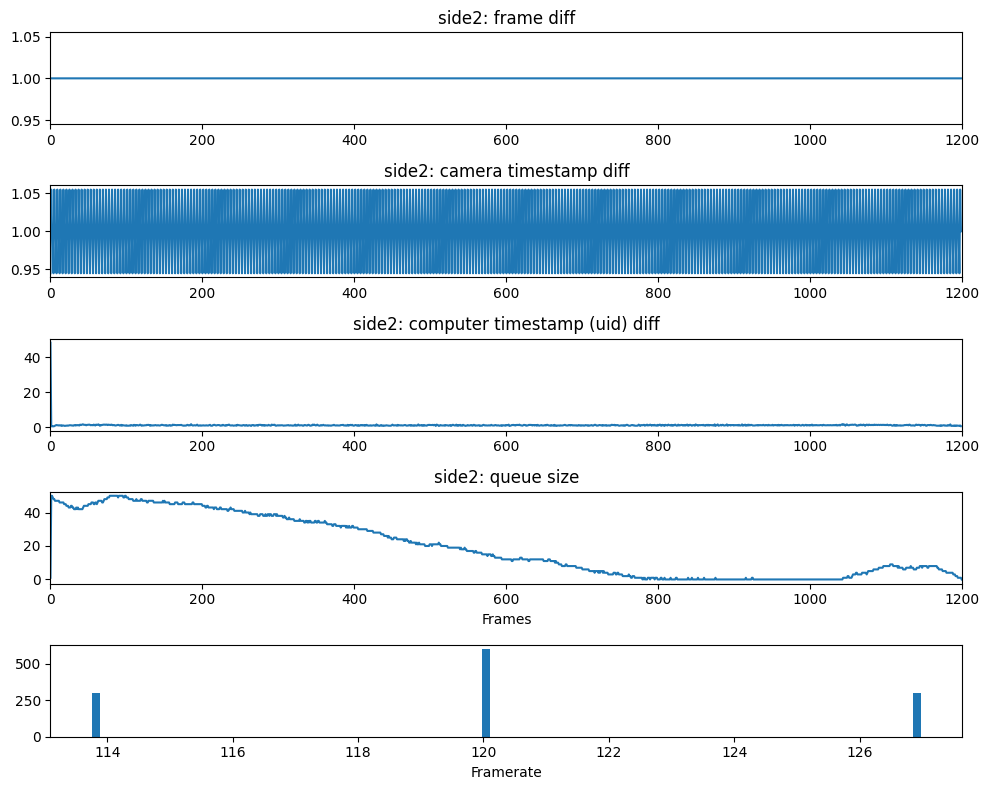

9.99180587
119.99832819009723
side3


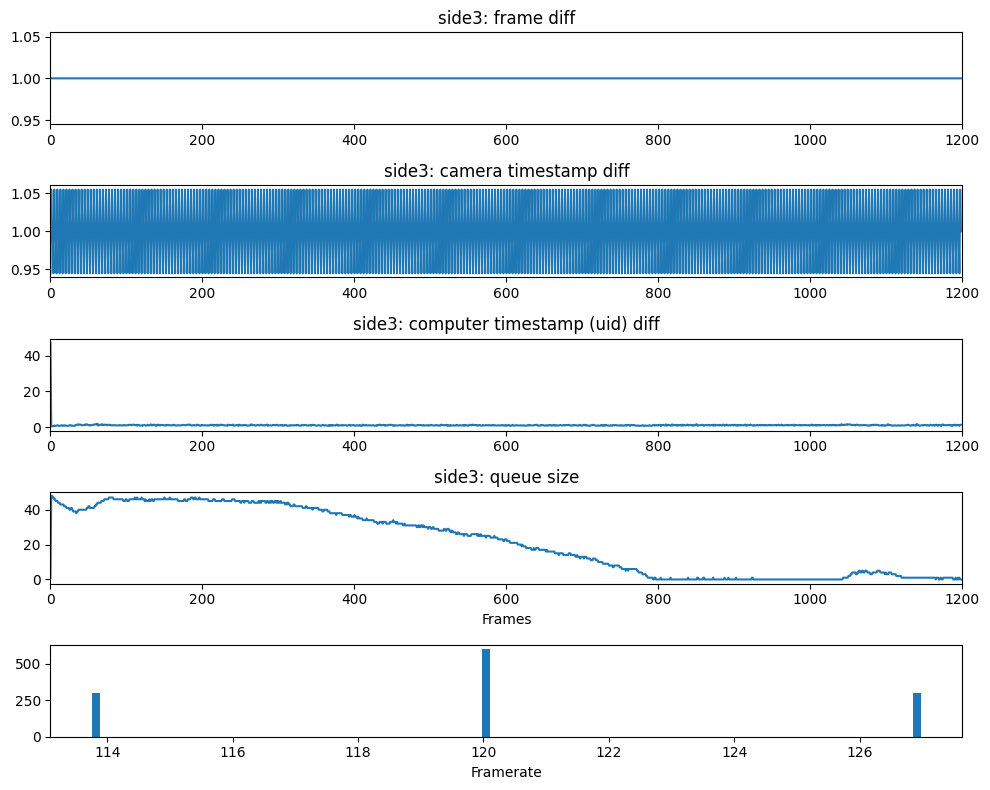

9.99177627
119.9986836774919
side4


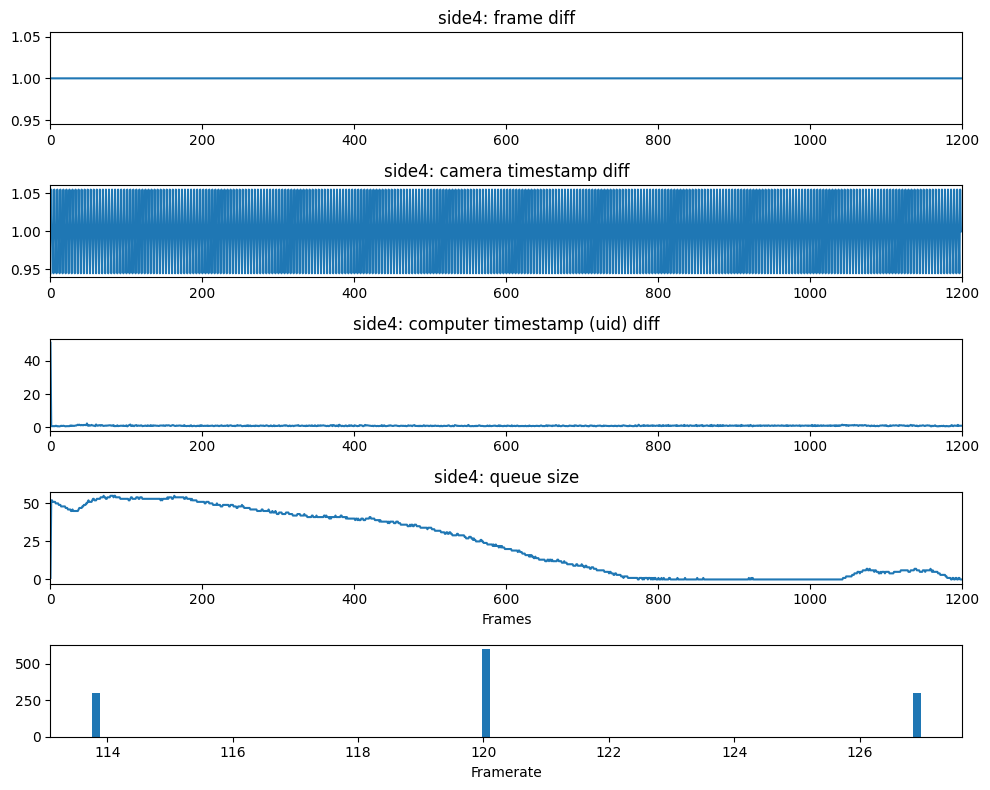

9.99178942
119.99852574955486
top


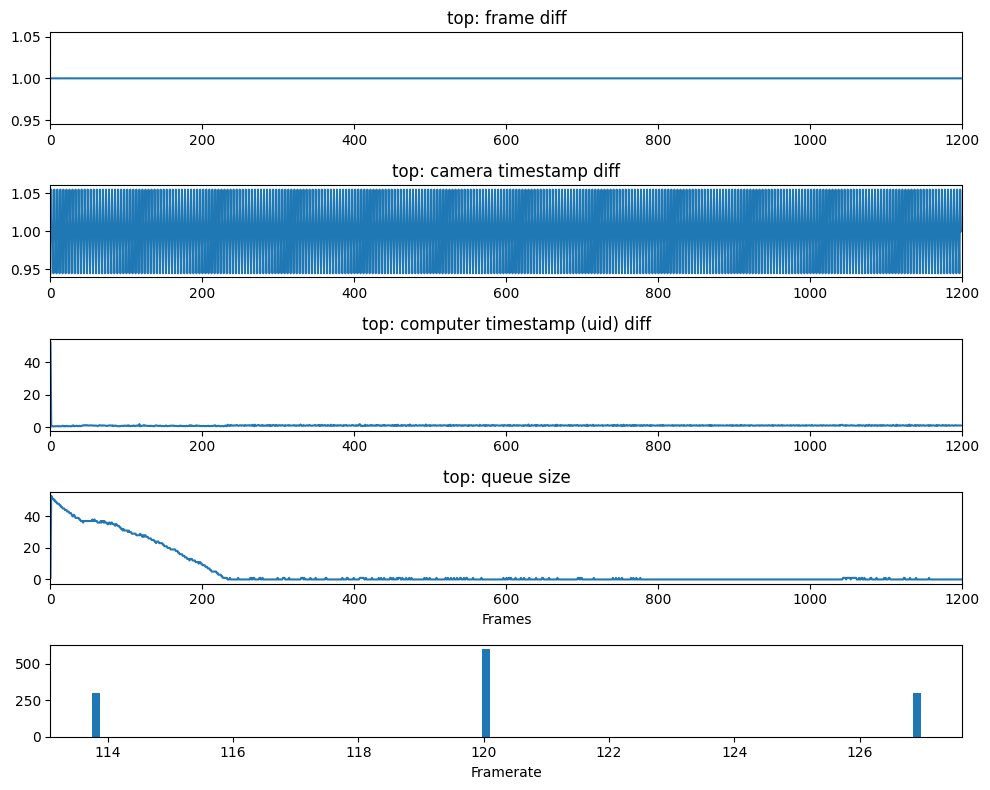

9.99179662
119.9984392796818


In [17]:
for cam in config["cameras"]:
    name = cam
    print(name)
    df = pd.read_csv(glob.glob(str(save_loc)+ f'\*.{name}.metadata.csv')[0])
    fig, axs = plt.subplots(ncols = 1, nrows = 5, gridspec_kw= {'height_ratios':[1,1,1,1,1]}, figsize=(10,8))
    nrows = len(df)
    axs[0].set_title(f"{name}: frame diff")
    axs[0].plot(np.diff(df.frames_received.values))
    axs[0].set_xlim([0, len(df)])
    axs[1].set_title(f"{name}: camera timestamp diff")
    axs[1].plot(np.diff(df.frame_timestamp.values) / np.median(np.diff(df.frame_timestamp.values)))
    #axs[1].plot(np.diff(df.frame_timestamp.values))
    axs[1].set_xlim([0, len(df)])
    axs[2].set_title(f"{name}: computer timestamp (uid) diff")
    axs[2].plot(np.diff(df.frame_image_uid.values) / np.median(np.diff(df.frame_image_uid.values)))
    axs[2].set_xlim([0, len(df)])
    axs[3].set_title(f"{name}: queue size")
    axs[3].plot(df.queue_size.values)
    axs[3].set_xlim([0, len(df)])
    axs[3].set_xlabel('Frames')
    axs[4].hist(1/(np.diff(df.frame_timestamp.values)* 1e-9), bins=100);
    axs[4].set_xlabel('Framerate')
    plt.tight_layout()
    plt.show()
    
    time_elapsed = (df.frame_timestamp.values[-1] - df.frame_timestamp.values[0]) * 1e-9
    avg_framerate = np.mean(np.diff(df.frame_timestamp.values))
    print(time_elapsed)
    print(1 / (avg_framerate* 1e-9))